IA & Data science (LU3IN0226) -- 2022-2023
--------
*&copy; Equipe pédagogique: Christophe Marsala, Olivier Schwander, Jean-Noël Vittaut.*

<font size="+1" color="RED"><b>[Q]</b></font> <font size="+1"><b>Indiquer dans la boîte ci-dessous vos noms et prénoms :</b></font>

Adelin-Flaviu FERCHE

Ce projet peut être fait en binôme (d'un même groupe). Le nom de chaque membre du binôme doit être indiqué, et un seul rendu sur un des deux comptes Moodle doit être fait.

Les groupes de plus de 2 personnes ne sont pas autorisés.

<font color="RED" size="+1"><b>[Q]</b></font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>projet-1</tt> et rajouter à la suite de <tt>projet-1</tt> les noms des membres du binômes séparés par un tiret.

<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au notebook** : *projet-1-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme

**Le compte-rendu doit être rendu sur la page Moodle.**

# Projet 1 - février-mars 2023


<font size="+1" color="RED"><b>Date de rendu : jeudi 22 mars, 18h au plus tard</b></font>
<br />


Vous devez compléter ce notebook en rajoutant vos expérimentations avec vos algorithmes d'apprentissage sur les 2 datasets fournis dans le répertoire data-projet:
- les données data-2D.pkl : données en 2 dimensions, 2 labels
- les données data-5D.pkl : données en 5 dimensions, 2 labels

## Travail à faire

Pour chaque ensemble de données:
- les 3 algorithmes d'apprentissage knn, perceptron et perceptron biais doivent être expérimentés et comparés (ATTENTION: on ne veut que des algorithmes que vous avez implémentés vous-même dans cette UE).
- des résultats d'expérimentations doivent fournir une comparaison des taux de bonne classification apprentissage / test avec validation croisée en 10.
- des courbes (coût, poids, variation d'accuracy,...) doivent être fournies pour étudier les modèles construits.

Vos **expérimentations doivent être expliquées**... (utilisez des boîtes Markdown pour saisir vos explications):
- une argumentation du type *"pourquoi vous avez fait cette expérimentation"* doit être fournie;
- une analyse succincte du résultat fourni doit être aussi donnée.



Par exemple (indicatif): choix de $k$ pour le knn:
- argumentation : pour décider quelle peut être la valeur de $k$ optimale, on décide de tester plusieurs valeurs différentes et de comparer les taux de bonne classification sur la base de test obtenus.
- analyse du résultat: on remarque que la valeur $k$ suivante fournie le meilleur résultat.
- étude du temps d'exécution.


## Travail à rendre
Ce qui doit être rendu : un fichier archive (`.tar`, `.tgz`, ou `.zip` uniquement) contenant uniquement ce notebook, dans lequel vous avez reporté toutes les fonctions que vous utilisez : ce notebook doit pouvoir être exécuté sans autre apport (pensez à vous en assurer avant de le rendre). Les fichiers de données ne doivent pas être inclus dans votre archive !



## Lecture des pickles



In [102]:
# Importation de librairies standards:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import math

# Importation de la librairie pickle
import pickle as pkl

# lecture des donnéees en dimension 2 dans un dataframe pandas
data2D = pkl.load(open('data-projet/data-2D.pkl', 'rb')) 
X2D = np.array(data2D[['x1', 'x2']], dtype=float) # conversion de type pour une meilleure compatibilité
Y2D = np.array(data2D['label'], dtype=float)

# pour les données en dimension 5, la méthode est la même, modifier seulement les noms des colonnes

In [104]:
data2D[0:5]

,x1,x2,label
0,0.830557,-2.250314,-1
1,0.627488,-2.533405,-1
2,-1.279837,-1.630564,-1
3,2.002088,-3.415239,-1
4,3.141847,-0.376081,-1


In [106]:
X2D[0:5]

array([[ 0.83055692, -2.25031368],
       [ 0.62748844, -2.53340502],
       [-1.27983681, -1.63056446],
       [ 2.00208794, -3.41523902],
       [ 3.14184699, -0.37608089]])

In [108]:
Y2D[0:5]

array([-1., -1., -1., -1., -1.])

***LES CLASSES CLASSIFIERS***

In [110]:
class Classifier:
    """ Classe (abstraite) pour représenter un classifieur
        Attention: cette classe est ne doit pas être instanciée.
    """
    
    def __init__(self, input_dimension):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension de la description des exemples
            Hypothèse : input_dimension > 0
        """
        self.input_dimension = input_dimension
        
    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        raise NotImplementedError("Please Implement this method")
    
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        raise NotImplementedError("Please Implement this method")
    
    def predict(self, x):
        """ rend la prediction sur x (soit -1 ou soit +1)
            x: une description
        """
        raise NotImplementedError("Please Implement this method")

    def accuracy(self, desc_set, label_set):
        """ Permet de calculer la qualité du système sur un dataset donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """ 
        bienClasse = 0
        for exemple in range(0, desc_set.shape[0]):
            if self.predict(desc_set[exemple])==label_set[exemple]:
                bienClasse+=1
        return bienClasse/len(label_set)

In [111]:
class ClassifierKNN(Classifier):
    """ Classe pour représenter un classifieur par K plus proches voisins.
        Cette classe hérite de la classe Classifier
    """
    
    def __init__(self, input_dimension, k):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
                - k (int) : nombre de voisins à considérer
            Hypothèse : input_dimension > 0
        """
        Classifier.__init__(self,input_dimension)
        self.k = k
        
    def score(self,x):
        """ rend la proportion de +1 parmi les k ppv de x (valeur réelle)
            x: une description : un ndarray
        """
        distance = []
        for description in self.desc:
            dist = math.sqrt((x[0]-description[0])**2+(x[1]-description[1])**2)
            distance.append(dist)
        index_sorted = np.argsort(distance)
        nb_posi = 0
        for i in range(0,self.k):
            if self.label[index_sorted[i]]==+1:
                nb_posi+=1
        proportion_posi = (nb_posi/self.k)
        return 2*(proportion_posi-0.5)
    
    def predict(self, x):
        """ rend la prediction sur x (-1 ou +1)
            x: une description : un ndarray
        """
        if self.score(x)>0:
            return 1
        return -1

    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """ 
        self.desc = desc_set
        self.label = label_set

In [112]:
class ClassifierPerceptron(Classifier):
    """ Perceptron de Rosenblatt
    """
    def __init__(self, input_dimension, learning_rate=0.01, init=True ):
        """ Constructeur de Classifier
            Argument:
                - input_dimension (int) : dimension de la description des exemples (>0)
                - learning_rate (par défaut 0.01): epsilon
                - init est le mode d'initialisation de w: 
                    - si True (par défaut): initialisation à 0 de w,
                    - si False : initialisation par tirage aléatoire de valeurs petites
        """
        self.rate = learning_rate
        if init:
            self.w = np.zeros(input_dimension)
        else:
            temp = []
            for i in range(0, input_dimension):
                v = random.random()
                v = 2*v-1
                v = v*0.001
                temp.append(v)
            self.w = np.array(temp)
        self.allw =[self.w.copy()]
        
    def train_step(self, desc_set, label_set):
        """ Réalise une unique itération sur tous les exemples du dataset
            donné en prenant les exemples aléatoirement.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
        """        
        shuffled = np.arange(len(desc_set))
        np.random.shuffle(shuffled)
        for i in shuffled:
            prediction = self.predict(desc_set[i])
            if prediction != label_set[i]:
                self.w = self.w + self.rate * desc_set[i] * label_set[i]
                self.allw.append(self.w)
     
    def train(self, desc_set, label_set, nb_max=100, seuil=0.001):
        """ Apprentissage itératif du perceptron sur le dataset donné.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
                - nb_max (par défaut: 100) : nombre d'itérations maximale
                - seuil (par défaut: 0.001) : seuil de convergence
            Retour: la fonction rend une liste
                - liste des valeurs de norme de différences
        """        
        listeConv = []
        for i in range(0,nb_max):
            w1 = self.w.copy()
            self.train_step(desc_set,label_set)
            conv = np.linalg.norm(np.absolute(np.subtract(self.w,w1)))
            listeConv.append(conv)
            if conv < seuil:
                break
        return listeConv
    
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        return np.dot(x,self.w)
    
    def predict(self, x):
        """ rend la prediction sur x (soit -1 ou soit +1)
            x: une description
        """
        if self.score(x) >= 0:
            return 1
        
        return -1

    def get_allw(self):
        """rend tous les poids w
        """
        return self.allw

In [113]:
class ClassifierPerceptronBiais(ClassifierPerceptron):
    """ Perceptron de Rosenblatt avec biais
        Variante du perceptron de base
    """
    def __init__(self, input_dimension, learning_rate=0.01, init=True):
        """ Constructeur de Classifier
            Argument:
                - input_dimension (int) : dimension de la description des exemples (>0)
                - learning_rate (par défaut 0.01): epsilon
                - init est le mode d'initialisation de w: 
                    - si True (par défaut): initialisation à 0 de w,
                    - si False : initialisation par tirage aléatoire de valeurs petites
        """
        super().__init__(input_dimension, learning_rate, init)
        
    def train_step(self, desc_set, label_set):
        """ Réalise une unique itération sur tous les exemples du dataset
            donné en prenant les exemples aléatoirement.
            Arguments:
                - desc_set: ndarray avec des descriptions
                - label_set: ndarray avec les labels correspondants
        """        
        shuffled = np.arange(len(desc_set))
        np.random.shuffle(shuffled)
        for i in shuffled:
            score = self.score(desc_set[i])
            if (score*label_set[i]) < 1:
                self.w = self.w + (self.rate*(label_set[i]-score))*desc_set[i]
                self.allw.append(self.w)

***LES FONCTIONS UTILES***

***Modélisation***

In [114]:
def plot2DSet(desc,labels):    
    """ ndarray * ndarray -> affichage
        la fonction doit utiliser la couleur 'red' pour la classe -1 et 'blue' pour la +1
    """
    classe_negatif = desc[labels == -1]
    classe_positif = desc[labels == +1]
    
    plt.scatter(classe_negatif[:,0], classe_negatif[:,1], marker='o', color='red')
    plt.scatter(classe_positif[:,0], classe_positif[:,1], marker='x', color='blue')

In [115]:
def plot_frontiere(desc_set, label_set, classifier, step=30):
    """ desc_set * label_set * Classifier * int -> NoneType
        Remarque: le 4e argument est optionnel et donne la "résolution" du tracé: plus il est important
        et plus le tracé de la frontière sera précis.        
        Cette fonction affiche la frontière de décision associée au classifieur
    """
    mmax=desc_set.max(0)
    mmin=desc_set.min(0)
    x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
    grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
    
    res=np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res=res.reshape(x1grid.shape)
    plt.contourf(x1grid,x2grid,res,colors=["darksalmon","skyblue"],levels=[-1000,0,1000])

***Validation croisée (avec distribution des classes)***

In [116]:
def crossval_strat(X, Y, n_iterations, iteration):
    Xneg= X[Y == -1]
    Xpos = X[ Y == 1]
    Yneg = Y[Y == -1]
    Ypos = Y[ Y == 1]
    
    Xapp = []
    Yapp = []
    Xtest = []
    Ytest = []
    a = int(iteration * (len(X)/n_iterations))//2    #divise par 2 car 2 classes
    b = int((iteration+1)*(len(X)/n_iterations))//2

    #classe négative -1
    for i in range(len(Xneg)):
        if i in range(a,b):
            Xtest.append(Xneg[i])
            Ytest.append(Yneg[i])
        else:
            Xapp.append(Xneg[i])
            Yapp.append(Yneg[i])
    
    #classe positive +1
    for i in range(len(Xpos)):
        if i in range(a,b):
            Xtest.append(Xpos[i])
            Ytest.append(Ypos[i])
        else:
            Xapp.append(Xpos[i])
            Yapp.append(Ypos[i])
    Xapp = np.array(Xapp)
    Yapp = np.array(Yapp)
    Xtest = np.array(Xtest)
    Ytest = np.array(Ytest)
    
    return Xapp, Yapp, Xtest, Ytest 

***COMPARAISON DATA 2D***

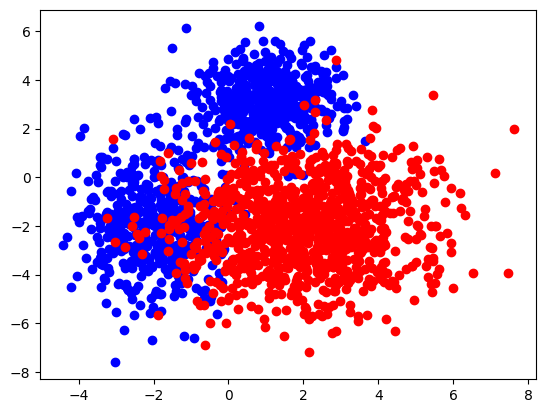

In [117]:
plt.figure()
plt.scatter(X2D[Y2D==1,0], X2D[Y2D==1,1], c='b')
plt.scatter(X2D[Y2D==-1,0], X2D[Y2D==-1,1], c='r')

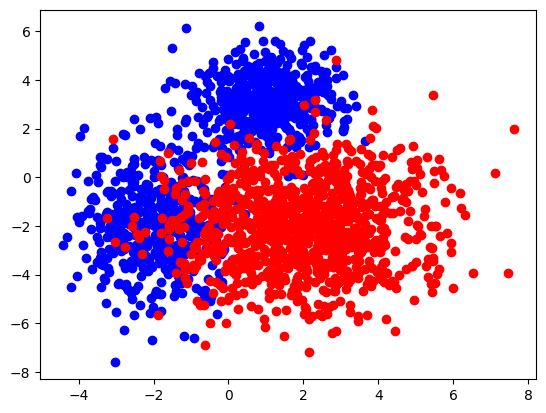

In [118]:
# mélange des index
index = np.random.permutation(len(X2D)) 
X2D_m = X2D[index]
Y2D_m = Y2D[index]

# check: malgré le mélange, les données doivent être les mêmes
plt.figure()
plt.scatter(X2D_m[Y2D_m==1,0], X2D_m[Y2D_m==1,1], c='b')
plt.scatter(X2D_m[Y2D_m==-1,0], X2D_m[Y2D_m==-1,1], c='r')

***Algorithme KNN***

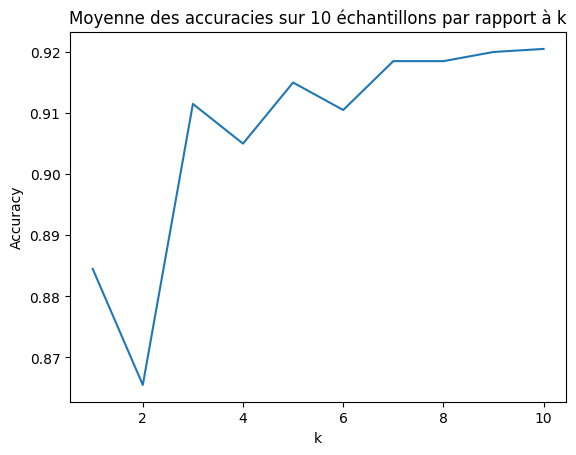

In [119]:
# Paramètres pour le knn:
perfK = []
kmax = 11
dim = 2
niter = 10

for k in range(1,kmax):
    perf = []
    for i in range(niter):
        Xapp,Yapp,Xtest,Ytest = crossval(X2D_m, Y2D_m, niter, i)
        knn = ClassifierKNN(dim, k)
        knn.train(Xapp, Yapp)
        perf.append(knn.accuracy(Xtest, Ytest))
    perfK.append(np.array(perf).mean())

plt.title("Moyenne des accuracies sur 10 échantillons par rapport à k")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.plot(np.arange(1,kmax),perfK)

Pour trouver le k le plus optimal, on varie la valeur de k de 1 à 10 et pour chaque valeur k, on le teste sur 10 échantillons puis on fait la moyenne du taux de bonne classification de chaque échantillon qu'on place dans un tableau qui contiendra toutes les moyennes pour chaque k. Après avoir varier la valeur de k, on trace la courbe du taux de bonne classification par rapport à k. Sur le graphique, on remarque que k=9 à le plus haut taux de bonne classification qui est environ de 93% et que juste après le taux de bonne classification descend pour k=10, donc k=9 est le k le plus optimal pour l'algorithme KNN.

Informations: j'ai testé avec un k qui varie entre 1 et 40 mais le temps d'exécution est assez long. La courbe obtenu montrait qu'au delà de k=9, l'évolution de la courbe devenait environ constante autour des 92% d'accuracy.

Accuracy Final:  0.93


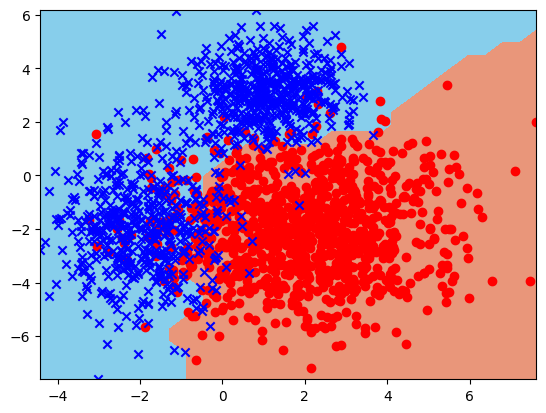

In [120]:
#Classifier KNN avec k optimale pour avoir la frontière la plus optimisée
knn_opti= ClassifierKNN(2,9)
knn_opti.train(X2D, Y2D)

plot_frontiere(X2D, Y2D, knn_opti)
plot2DSet(X2D, Y2D)

print("Accuracy Final: ",knn_opti.accuracy(X2D, Y2D))

***Algorithme PERCEPTRON***

Learning_rate  optimale =  0.001


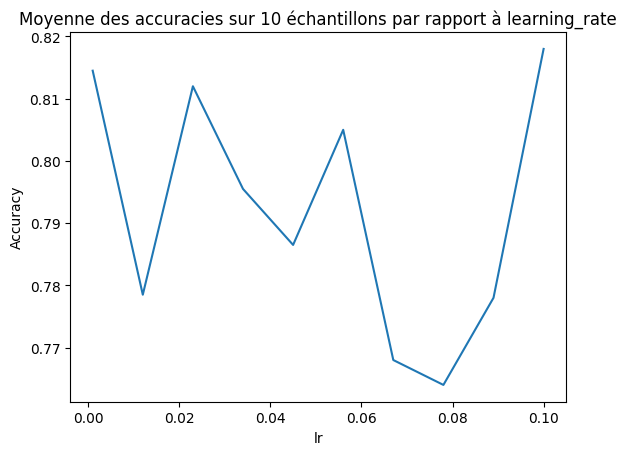

In [121]:
def lrOptiPercepton(X2D_m,Y2D_m, dim, niter, init):
    perfP = []
    lrValues = np.linspace(0.001,0.1, 10)
    moyMax = 0
    lr_opti = 0
    for lr in lrValues:
        perf= []
        for i in range(niter):
            Xapp,Yapp,Xtest,Ytest = crossval_strat(X2D_m, Y2D_m, niter, i)
            perceptron= ClassifierPerceptron(dim, lr, init)
            perceptron.train(Xapp, Yapp)
            perf.append(perceptron.accuracy(Xtest, Ytest)) 
        moy = np.array(perf).mean()
        if (moy > moyMax):
            moyMax = moy
            lr_opti = lr
        perfP.append(moy)
    return (perfP, lr_opti, lrValues)

x, learning_rate, y = lrOptiPercepton(X2D_m, Y2D_m, 2, 10, True)

plt.title("Moyenne des accuracies sur 10 échantillons par rapport à learning_rate")
plt.xlabel("lr")
plt.ylabel("Accuracy")
plt.plot(y,x)

print("Learning_rate  optimale = ", learning_rate)

Learning_rate  optimale =  0.001


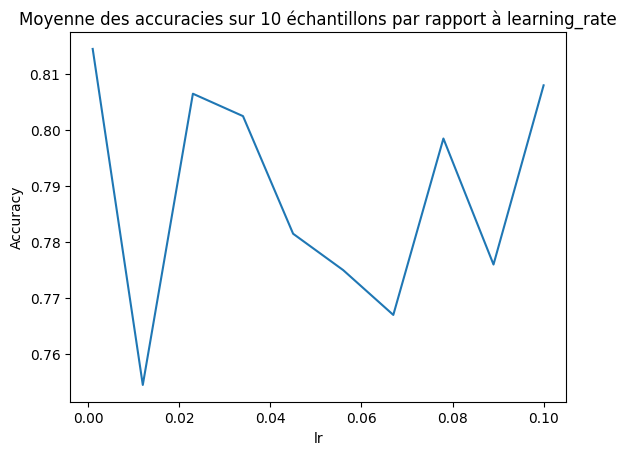

In [122]:
x2, learning_rate2, y2 = lrOptiPercepton(X2D_m, Y2D_m, 2, 10, False)

plt.title("Moyenne des accuracies sur 10 échantillons par rapport à learning_rate")
plt.xlabel("lr")
plt.ylabel("Accuracy")
plt.plot(y2,x2)

print("Learning_rate  optimale = ", learning_rate2)

On cherche le learning rate le plus optimale à la fois avec des poids initialisés à 0 ou aléatoirement. Dans les deux cas on obteint un learning_rate optimale de 0.001 avec une accuracy de 83%

Accuracy Final:  0.8395


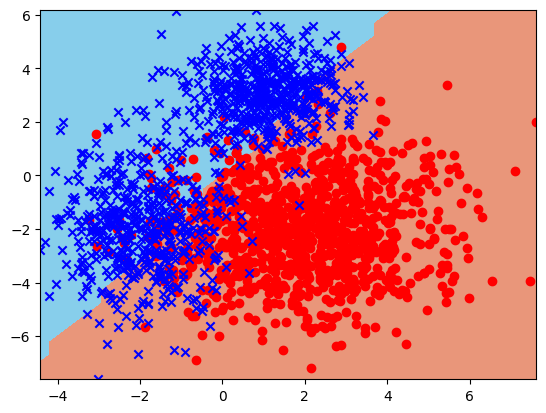

In [123]:
#Classifier Perceptron avec learning_rate optimale pour avoir la ligne de frontière la plus optimisée
perceptron_opti= ClassifierPerceptron(2,0.001)
perceptron_opti.train(X2D, Y2D)

plot_frontiere(X2D, Y2D, perceptron_opti)
plot2DSet(X2D, Y2D)

print("Accuracy Final: ",perceptron_opti.accuracy(X2D, Y2D))

***Algorithme PERCEPTRON BIAIS***

Learning_rate  optimale =  0.07800000000000001


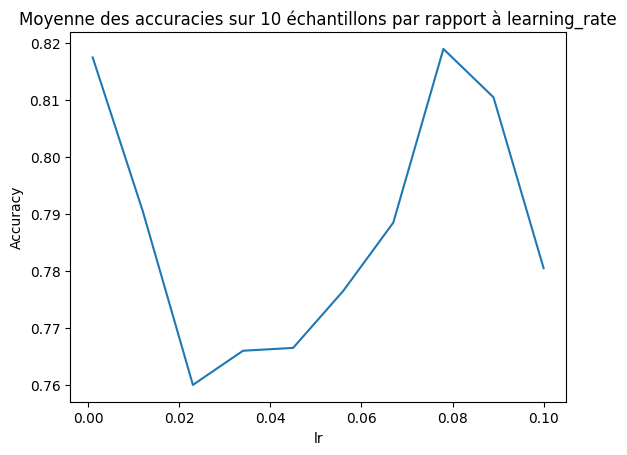

In [125]:
def lrOptiPerceptonBiais(X2D_m,Y2D_m, dim, niter, init):
    perfPB = []
    moyMax = 0
    lr_opti = 0
    lrValues = np.linspace(0.001,0.1,10)
    for lr in lrValues:
        perf= []
        for i in range(niter):
            Xapp,Yapp,Xtest,Ytest = crossval_strat(X2D_m, Y2D_m, niter, i)
            perceptronBiais = ClassifierPerceptronBiais(dim, lr, init)
            perceptronBiais.train(Xapp, Yapp)
        moy = np.array(perf).mean()
        if (moy > moyMax):
            moyMax = moy
            lr_opti = lr
        perfPB.append(moy)
    return (perfPB, lr_opti, lrValues)

x3, learning_rate3, y3 = lrOptiPercepton(X2D_m, Y2D_m, 2, 10, True)
plt.title("Moyenne des accuracies sur 10 échantillons par rapport à learning_rate")
plt.xlabel("lr")
plt.ylabel("Accuracy")
plt.plot(y3,x3)

print("Learning_rate  optimale = ", learning_rate3)

Learning_rate  optimale =  0.1


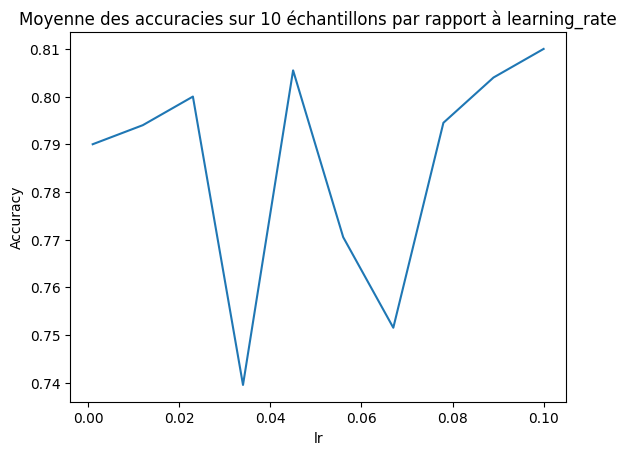

In [126]:
x4, learning_rate4, y4 = lrOptiPercepton(X2D_m, Y2D_m, 2, 10, False)
plt.title("Moyenne des accuracies sur 10 échantillons par rapport à learning_rate")
plt.xlabel("lr")
plt.ylabel("Accuracy")
plt.plot(y4,x4)

print("Learning_rate  optimale = ", learning_rate4)

On fait la même chose que pour le perceptron sans biais, on essaye de trouver le learning le plus optimale avecles poids initialisatés à zero ou aléatoirement. Dans le cas où les poids sont initialisés à zero le learning rate optimale est de 0,078 avec une accuracy de 82% alors que dans l'autre cas le learning rate le plus optimale est 0.1 avec une accuracy de 81%. Nous obterons pour le premier cas pour tracé la ligne de frontière.

Accuracy Final:  0.8205


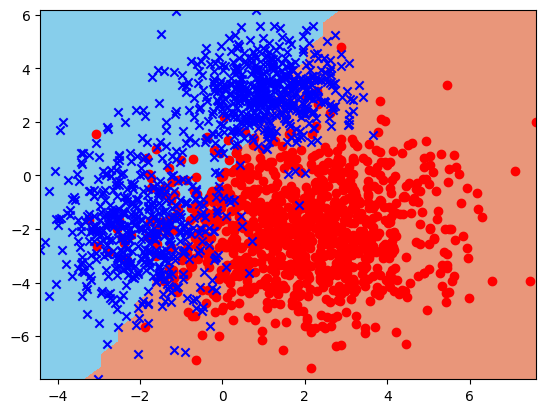

In [127]:
#Classifier Perceptron Biais avec learning_rate optimale pour avoir la ligne de frontière la plus optimisée
perceptronBiais_opti= ClassifierPerceptronBiais(2,0.078)
perceptronBiais_opti.train(X2D, Y2D)

plot_frontiere(X2D, Y2D, perceptronBiais_opti)
plot2DSet(X2D, Y2D)

print("Accuracy Final: ",perceptronBiais_opti.accuracy(X2D, Y2D))